# Sparkify Project

### Project Overview
This project aims to predict churn based on user activities in a music app called Sparkify which has a similar architecture with Spotify. The definition of churn is to quit getting services from a service provider. The goal with predicting churn is to decrease the number of churners with some offers in order to save revenue. This workspace contains a tiny subset (128MB) of the full dataset available (12GB). 

### Problem Statement
Churn is a classification problem where the customers labeled as churned or stayed. Therefore, some classification algorithms will be compared based on their performance (time, accuracy, F1 Score) and the best model will be tuned and analyzed further. 

### Metrics
Accuracy is the ratio between the number of correctly classified customers to the total number of customers.


F1 Score = (2 * Precision * Recall) / (Precision + Recall) 

The both metrics have been used in the project but for a classification problem F1 Score can be more meaningful since the data can be imbalanced.

In [1]:
# importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import *
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# creating a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
#configuration of the session
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.port', '46423'),
 ('spark.driver.host',
  '2bf4f2c17e4bff81f3063784ab11b12c97e057db-7f48f9d579-j9wfj'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1695754963289'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Loading and cleaning the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#loading the dataset into df
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
#printing the schema to see the column names and their types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#taking a sample to have an insight about the data
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
#length of the dataset (which will be used for comparing the missing values)
df.count()

286500

In [8]:
#dropping duplicates in userId column
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



When we sort the result based on the userId, it is seen that there are empty strings which also need to be cleared from the dataset.

In [9]:
#dropping duplicates in sessionId column
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [10]:
#dropping empty strings from the userId column by filtering 
df = df.filter(df["userId"] != "")

In [11]:
#new length after cleaning the dataset
df.count()

278154

8346 rows with missing values have been dropped.

In [12]:
#converting json to pandas dataframe 
df2 = df.toPandas()

In [13]:
df2.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
Performing EDA on the data and doing basic manipulations within Spark. 

### Define Churn

A column `Churn` will be created to use as the label for the model. `Cancellation Confirmation` events will be used to define churn, which happen for both paid and free users. 

### Explore Data
After defining churn,some exploratory data analysis will be performed to observe the behavior for users who stayed vs users who churned. Starting by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

##### Defining Churn

Cancellation Confirmation is the last step of churning and it will be used to define users who churned. First, the duplicates will be dropped on page column to see the total list of pages.

In [14]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [15]:
#number of churners
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [16]:
#let's see the userIds of the churners
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



Now, the churners will be flagged with 1 and other users will be flagged with 0 with the help of udf which stands for user defined functions.

In [17]:
#flagging the users
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [18]:
#adding a column to the data which contains the flags we created in the previous step
df = df.withColumn("churn", churn_event("page"))

In [19]:
#checkpoint to see whether the column was added correctly or not
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

Now the records will be sorted for a userId in reverse time order and the values will be added up in the churn column.

In [20]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [21]:
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [22]:
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [23]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



Now, I will make some analysis to have insight about the characteristics of the churners.

In [24]:
df_churn = df_churn.toPandas()

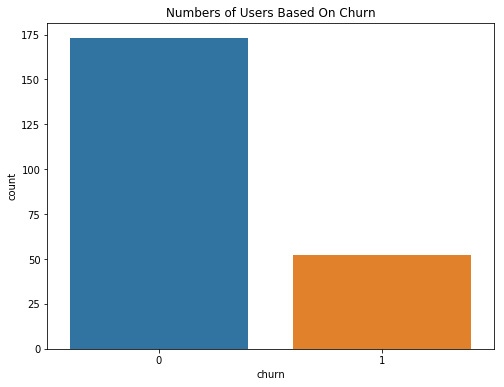

In [25]:
#plotting number of users based on churn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Numbers of Users Based On Churn");

The churn rate can be calculated by dividing the number of churners to total number:

In [26]:
52/(52+173)

0.2311111111111111

23% of the users have been churned. This can be considered as a high rate.

### Gender

Now, let's take a look at the gender distribution.

In [27]:
# creating gender dataframe grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [28]:
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [29]:
#converting to dataframe for plotting
df_gender = df_gender.toPandas()

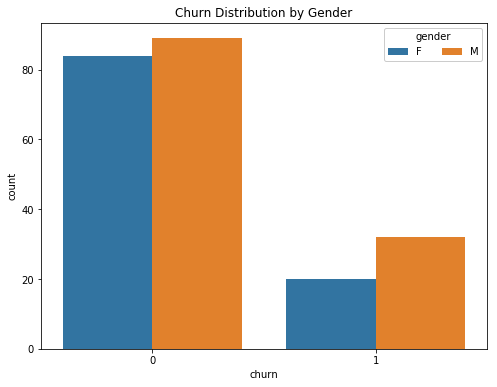

In [30]:
#plotting the gender distribution
plt.figure(figsize=[8,6])
ax = sns.barplot(data=df_gender, x='churn', y='count', hue='gender')
ax.legend(loc=1, ncol=2, framealpha=1, title='gender')
plt.title("Churn Distribution by Gender");

Let's calculate the following metrics:
    - Male churn rate
    - Female churn rate

In [31]:
#Male churn rate
32/(32+89)

0.2644628099173554

In [32]:
#Female churn rate
20/(20+84)

0.19230769230769232

We can say that there are more male users who churned. (26% vs 19%)

### Level

We also know that there are two types of users: free and paid. Let's take a look at to their churn distribution.

In [33]:
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [34]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [35]:
df_level = df_level.toPandas()

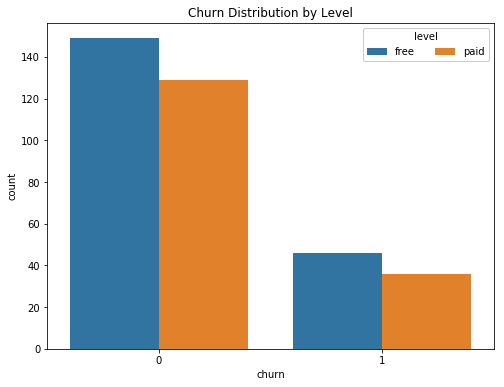

In [36]:
plt.figure(figsize=[8,6])
ax = sns.barplot(data=df_level, x='churn', y='count', hue='level')
ax.legend(loc=1, ncol=2, framealpha=1, title='level')
plt.title("Churn Distribution by Level");

In [37]:
#Free churn rate
46/(46+149)

0.2358974358974359

In [38]:
#Paid churn rate
36/(36+129)

0.21818181818181817

Even though the difference is not big, the free users tend to churn more. (23.5% vs 21.8%)

### Visited Pages

Let's take a look at the page visitations for the users to see whether there is a pattern or not.

In [39]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [40]:
df_page.show(20)

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
|               Error|    0|  220|
|              Cancel|    1|   52|
|            Settings|    1|  270|
|          Add Friend|    1|  636|
|             Upgrade|    0|  387|
|           Downgrade|    1|  337|
|              Logout|    1|  553|
|    Submit Downgrade|    1|    9|
|       Save Settings|    0|  252|
|           Thumbs Up|    0|10692|
+--------------------+-----+-----+
only showing top 20 rows



In [41]:
df_page = df_page.toPandas()

In [42]:
# creating total counts for churners and the others
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [43]:
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])
) 

In [44]:
df_page.head(20)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


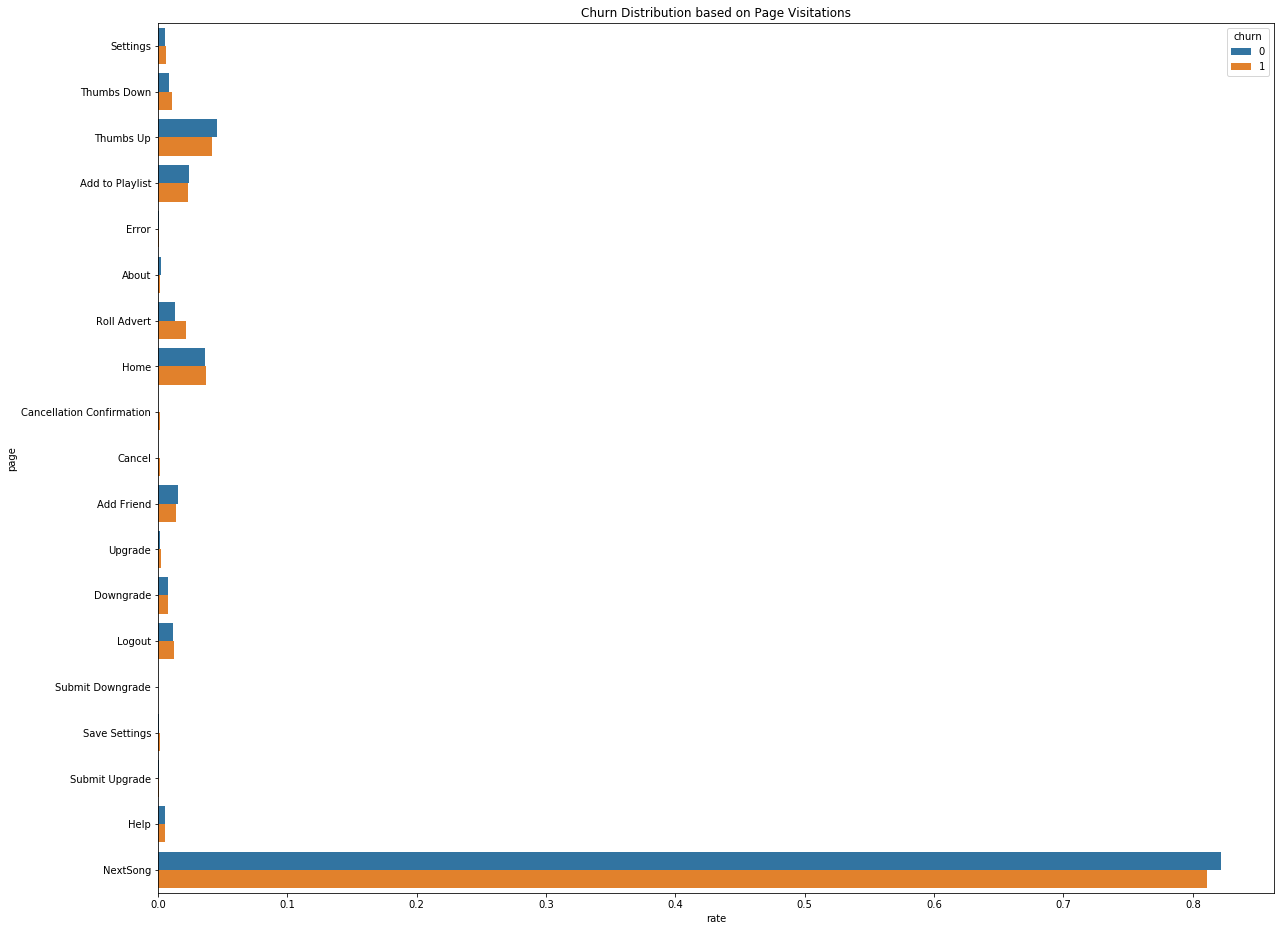

In [45]:
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Churn Distribution based on Page Visitations');

This analysis has given us the following insights:
    - The most popular action is skipping to the next song.
    - Churners tend to give thumbs down and roll advert.
    - Non-churners tend to give thumbs up and add friends.

### Songs Per Session

Let's take a look at how many songs (average) have been listened to per session by churners and non-churners.

In [46]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [47]:
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [48]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

In [49]:
df_songs = df_songs.toPandas()

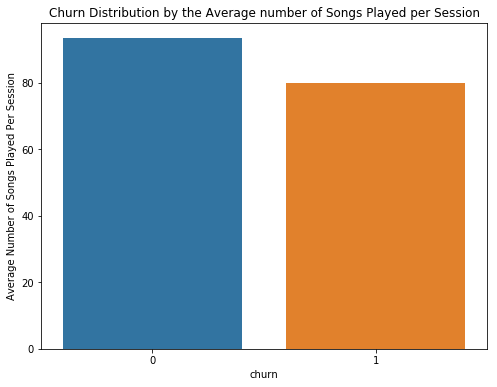

In [50]:
plt.figure(figsize=[8,6])
ax = sns.barplot(data=df_songs, x ='churn', y='avg(count)')
plt.title("Churn Distribution by the Average number of Songs Played per Session")
plt.ylabel("Average Number of Songs Played Per Session");

We see that churners listen to fewer songs on average per session.

### Number of Unique Artists

In [51]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [52]:
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [53]:
df_artists = df_artists.toPandas()

Let's use a boxplot to see the distribution.

Text(0.5,1,'Number of Unique Artists')

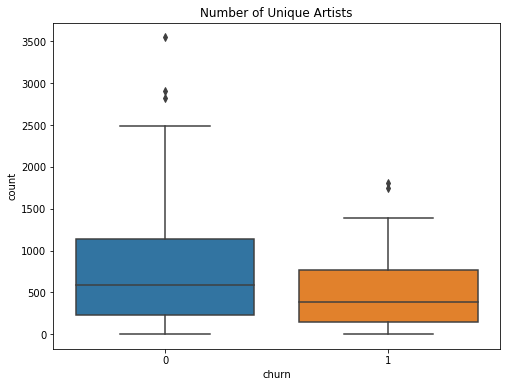

In [54]:
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = df_artists, x = 'churn', y='count')
plt.title("Number of Unique Artists")

We can see that non-churners listen to a larger number of different artists compared to churners.

### Days Since Registration

In [55]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [56]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [57]:
# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [58]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [59]:
# just get those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [60]:
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [61]:
# need to take the difference of the registration from ts 
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [62]:
df_days.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [63]:
#converting to day
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [64]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [65]:
df_days_pd = df_days.toPandas()

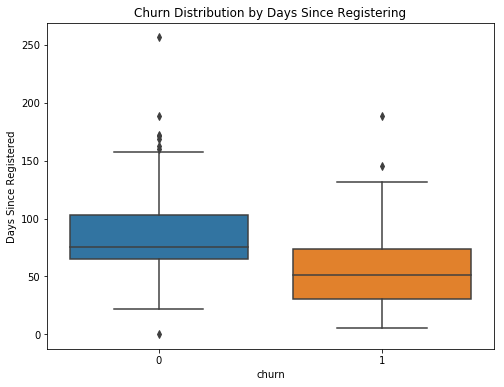

In [66]:
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.title('Churn Distribution by Days Since Registering')
plt.ylabel("Days Since Registered");

On average, the users who registered to Sparkify for longer tend to stay in the app whereas the newest users tend to churn.

# Feature Engineering

EDA process has been finished successfully and now it is time to choose features for training our model. In the previous step, the possible features were detected as follows: 

Categorical:

- Gender

- Level

Numerical:

- Songs per session

- Roll-ads actions

- Thumb down actions

- Thumbs up actions

- Number of added friends

- Number of songs added to a playlist

- Number of different artists listened to on Sparkify

- Number of days since registering

A churn flag will be added to these features to from a dataframe. Categorical variables should be converted into numerical variables for being able to perform operations. 

### Gender

Let's assign 1 for females and 0 for males.

In [67]:
newGender = df.select(['userId', 'gender']).dropDuplicates()

In [68]:
# creating the gender column where females are 1 and males are 0
newGender = newGender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [69]:
newGender.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



### Level

In [70]:
levelDF = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [71]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [72]:
levelDF = levelDF.withColumn("Rank", dense_rank().over(w))

In [73]:
levelDF.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [74]:
levelDF2 = levelDF.filter(levelDF.Rank == 1).drop(levelDF.Rank)

In [75]:
levelDF2 = levelDF2.drop('ts')

In [76]:
levelDF2 = levelDF2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

In [77]:
levelDF2.show()

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



### Average number of songs per session

In [78]:
song2 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

In [79]:
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [80]:
song2 = song2.groupby('userId').agg({"count":"avg"})

In [81]:
song2 = song2.withColumnRenamed("avg(count)", "avg_song")

In [82]:
song2.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



### Roll-Ad Actions

In [83]:
rollAds = df.select(["userId", "page"])

In [84]:
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [85]:
#creating rollad column
rollAds = rollAds.withColumn("rollad", rollad_event("page"))

In [86]:
rollAds = rollAds.groupby('userId').sum("rollad")

In [87]:
rollAds = rollAds.withColumnRenamed("sum(rollad)", "roll_ad")

In [88]:
rollAds.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
+------+-------+
only showing top 2 rows



### Thumbs Down

In [89]:
thumbsdown = df.select(["userId", "page"])

In [90]:
thumbsdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [91]:
thumbsdown = thumbsdown.withColumn("Thumbs Down", thumbsdown_event("page"))

In [92]:
thumbsdown = thumbsdown.groupby('userId').sum("Thumbs Down")

In [93]:
thumbsdown = thumbsdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [94]:
thumbsdown.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
+------+-----------+
only showing top 2 rows



### Thumbs Up

In [95]:
thumbsup = df.select(["userId", "page"])

In [96]:
thumbsup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [97]:
thumbsup = thumbsup.withColumn("Thumbs Up", thumbsup_event("page"))

In [98]:
thumbsup = thumbsup.groupby('userId').sum("Thumbs Up")

In [99]:
thumbsup = thumbsup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [100]:
thumbsup.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
+------+---------+
only showing top 2 rows



### Adding Friends

In [101]:
friends = df.select(["userId", "page"])

In [102]:
addFriends = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [103]:
friends = friends.withColumn("Add Friend", addFriends("page"))

In [104]:
friends = friends.groupby('userId').sum("Add Friend")

In [105]:
friends = friends.withColumnRenamed("sum(Add Friend)", "add_friend")

In [106]:
friends.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
+------+----------+
only showing top 2 rows



### Number of songs added to a playlist

In [107]:
playlist = df.select(["userId", "page"])

In [108]:
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [109]:
playlist = playlist.withColumn("Playlist", add_playlist("page"))

In [110]:
playlist = playlist.groupby('userId').sum("Playlist")

In [111]:
playlist = playlist.withColumnRenamed("sum(Playlist)", "playlist")

In [112]:
playlist.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
+------+--------+
only showing top 2 rows



### Number of unique artists listened to on Sparkify

In [113]:
artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count()

In [114]:
artists = artists.withColumnRenamed("count", "num_artists")

In [115]:
artists.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



### Number of days since registering

In [116]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [117]:
days2 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

In [118]:
days2.show(5)

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



### Churn Flag

In [119]:
flag = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [120]:
flag = flag.drop('count')

In [121]:
flag = flag.withColumnRenamed("churn", "label")

In [122]:
flag.show(2)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
+------+-----+
only showing top 2 rows



## Creating a Dataframe of Features 

At this step, we're going to merge all of the dataframes we have created with the help of the userId. Afterwards, in order to create an anonym dataset, we're going to drop the userId. 

In [123]:
feature_df = newGender.join(levelDF2, ["userId"]).join(song2 , ["userId"]).join(rollAds, ["userId"]).join(thumbsdown, ["userId"]).join(thumbsup, ["userId"]).join(friends, ["userId"]).join(playlist, ["userId"]).join(artists, ["userId"]).join(days2, ["userId"]).join(flag, ["userId"])

In [124]:
feature_df.show(3)

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+-----------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|             days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+-----------------+-----+
|100010|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253| 55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|          6|       21|         4|       8|        340|70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|          0|        0|         0|       0|          9|71.31688657407408|    1|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+-----------------+-----+
only showing top 3 rows



In [125]:
feature_df = feature_df.drop('userId')

In [126]:
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



For creating a consistent environment for our model, I'm going to convert these data types to float.

In [127]:
for f in feature_df.columns:
    feature_df = feature_df.withColumn(f, feature_df[f].cast('float'))

In [128]:
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



It worked!

### Vector Assembler

Vector assembler is going to tranform our features into a vector. The vector can then be standardized and be ready to be used in our algorithms. 

In [129]:
vector_assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vector_features")

In [130]:
feature_df = vector_assembler.transform(feature_df)

In [131]:
feature_df.show(3)

+------+-----+---------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|     days|label|     vector_features|
+------+-----+---------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|       4.0|     7.0|      253.0|55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|       4.0|     8.0|      340.0| 70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0| 71.31689|  1.0|(10,[2,3,8,9],[8....|
+------+-----+---------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
only showing top 3 rows



### Standardization

In [132]:
scaler = StandardScaler(inputCol="vector_features", outputCol="features", withStd=True)

In [133]:
smodel = scaler.fit(feature_df)

In [134]:
feature_df = smodel.transform(feature_df)

In [135]:
feature_df.head(2)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_down=5.0, thumbs_up=17.0, add_friend=4.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vector_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 2.413, 0.3823, 0.2596, 0.1943, 0.214, 0.4189, 1.4775])),
 Row(gender=0.0, level=1.0, avg_song=64.5, roll_ad=7.0, thumbs_down=6.0, thumbs_up=21.0, add_friend=4.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vector_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]))]

# Modeling

The data set which contains 225 data points will be separated into train, test and validation groups with the ratio of 0.6 0.2 0.2 simultaneously.

### Train & Test & Validation

In [136]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [137]:
train, test, validation = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 42)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(validation.count()))

Training Dataset:142
Test Dataset:49
Validation Dataset:34


After splitting the dataset into train, test and validation sets, the following machine learning classification algorithms will be used because our main goal is to predict whether a customer will churn or not. 

- Logistic Regression
- Random Forest Classifier
- Gradient-Boosted Tree Classifier
- Naive Bayes


The accuracy of these models will be evaluated with the help of test and validation sets and the F1 Score will be our metric to look at since we are using a small subset. Churn prediction is a classification problem, therefore the most popular classification algorithms will be tested at this step. 

In [138]:
#defining our models
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=42)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=42)
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [139]:
#creating a list of models
model_list = [lr,rf,gbt,nb]

In [140]:
# defining an evaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [141]:
# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'prediction started')
    predictions = model.transform(validation)
    print(model_name, 'prediction ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 158.63949513435364 seconds
LogisticRegression prediction started
LogisticRegression prediction ended
F1 for LogisticRegression is: 0.8353681095079541
The accuracy of the LogisticRegression model is: 0.8529411764705882
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 188.03597903251648 seconds
RandomForestClassifier prediction started
RandomForestClassifier prediction ended
F1 for RandomForestClassifier is: 0.8442906574394463
The accuracy of the RandomForestClassifier model is: 0.8529411764705882
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 219.78659439086914 seconds
GBTClassifier prediction started
GBTClassifier prediction ended
F1 for GBTClassifier is: 0.7036625971143174
The accuracy of the GBTClassifier model is: 0.7352941176470589
NaiveBayes training started
N

Based on the time, accuracy and F1 score, the best model is Logistic Regression. Now we can move on with tuning the model by choosing from Logistic Regression parameters.

In [142]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [143]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter,[1, 5, 10]) \
    .addGrid(lr.threshold,[0, 0.5, 1]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [174]:
model = crossval.fit(train)

In [176]:
pred = model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

# Calculate metrics
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
#evalMetrics['prediction_time'] = prediction_time

In [183]:
# Train the model and evaluate performance
classifier = LogisticRegression(labelCol="label", featuresCol="features")
paramGrid=ParamGridBuilder().build()

# Save the best model
bestModel = model.bestModel

# Show metrics
print("Logistic Regression:")
print(evalMetrics)

Logistic Regression:
{'precision': 0.8782961460446248, 'recall': 0.8529411764705883, 'f1': 0.8353681095079541, 'accuracy': 0.8529411764705882, 'confusion_matrix': DataFrame[label: float, 0.0: bigint, 1.0: bigint]}


In [186]:
feature_cols = feature_df.drop('label').drop('userId').columns

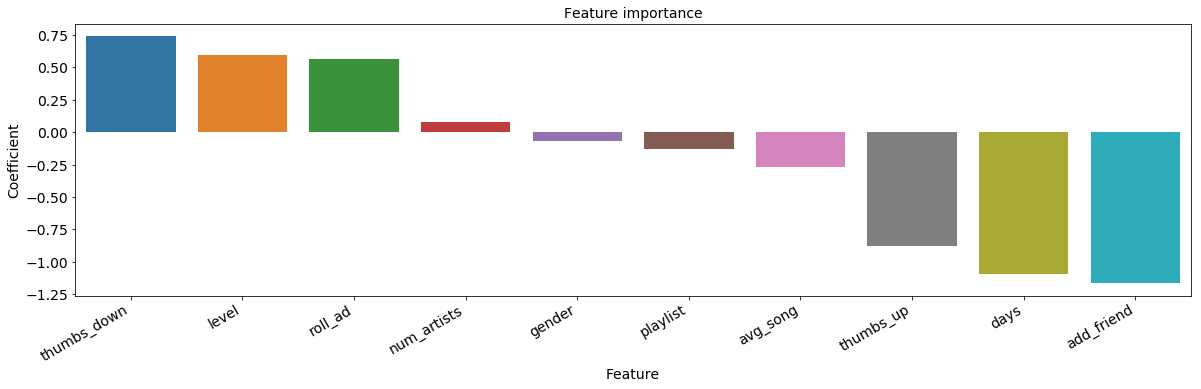

In [187]:
# Feature importance
feature_coef = bestModel.coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

This result shows us that the most important features were thumbs down, level and rolling adverts. Giving a thumbs up, registration days and adding a friend were not related as much as expected. Number of unique artists, gender, playlist and average song were the features that have a very low impact and they could or could not be included in the model. 

### Reflection
The chance to work with Spark really helped me to understand some context deeply since I'm using PySpark in my current job. Overall, the project has made me to work on different classification algorithms on a very interesting dataset. I'm also a musician that's why this project brought up my job and my hobby in a very great way to enhance my ability on data science. Thank you for providing the dataset. However, this project can be developed by comparing more algorithms, considering overfitting problem, choosing better features and applying a more sofisticated grid search. 